In [1]:
# All imported libraries are listed herefor readbility

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from zlib import crc32



# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Transforming & Manipulating data
from sklearn.compose import ColumnTransformer


# The Linear Regression model
from sklearn.linear_model import LinearRegression



In [2]:
def load_olo_data_from_file(file_name):
    print(file_name)

    return pd.read_csv(file_name,
                    parse_dates=['Time'],
                    header=18
                    )

In [3]:
file_name = "tzvolcano_data_instrument_id_1_2021-01-01_to_2021-01-03.csv"
original_data = load_olo_data_from_file(file_name)

tzvolcano_data_instrument_id_1_2021-01-01_to_2021-01-03.csv


In [4]:
# Calculate the seconds_since_epoch variable
original_data["seconds_since_epoch"] = original_data['Time'].astype(np.int64)

# Show all the keys (variable names) in the loaded data set
original_data.keys()

Index(['Time', 'Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

In [5]:
# Remove the "Time" variable from the data set, as it is not useful for the model
height_data = original_data.drop(["Time", "Longitude", "Latitude"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(height_data.keys())
print(type(height_data))

Index(['Height', 'seconds_since_epoch'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [6]:
# swap the order of the columns
columns_titles = ["seconds_since_epoch","Height"]
height_data=height_data.reindex(columns=columns_titles)

height_data.keys()

Index(['seconds_since_epoch', 'Height'], dtype='object')

In [7]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler()),
])

# Test that the pipeline works
height_data_imputed = num_pipeline.fit_transform(height_data)

height_data_imputed

array([[-1.72550905,  1.08135329],
       [-1.72549562, -3.99411318],
       [-1.72548219, -3.96143851],
       ...,
       [ 1.75263381, -0.84645264],
       [ 1.75264724, -0.80288641],
       [ 1.75266067, -0.74842861]])

<AxesSubplot:xlabel='seconds_since_epoch', ylabel='Height'>

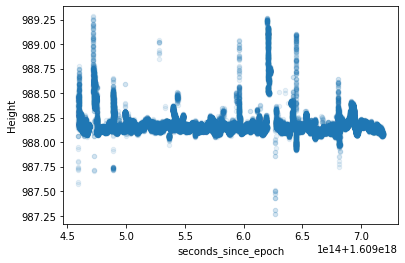

In [8]:
height_data.plot(kind="scatter", x="seconds_since_epoch", y="Height", alpha=0.1)

In [9]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

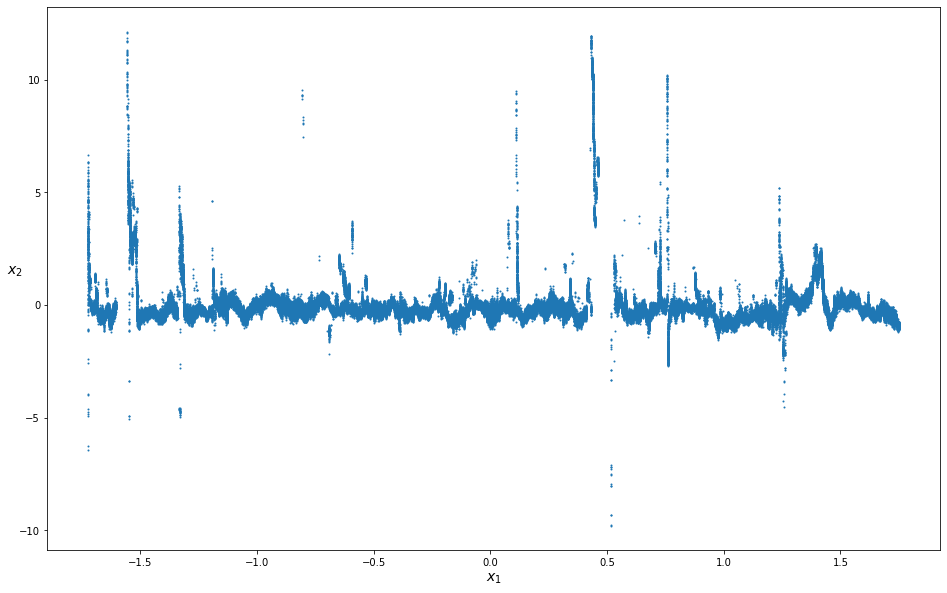

In [10]:
plt.figure(figsize=(16, 10))
plot_clusters(height_data_imputed)
plt.show()

In [11]:
from sklearn.mixture import GaussianMixture

In [12]:

N_COMPONENTS = 1
N_INIT = 10
COVARIANCE_TYPE = "full"

gm = GaussianMixture(n_components=N_COMPONENTS, n_init=N_INIT,covariance_type=COVARIANCE_TYPE, random_state=42)
gm.fit(height_data_imputed)

GaussianMixture(n_init=10, random_state=42)

In [13]:
gm.weights_

array([1.])

In [14]:
gm.means_

array([[1.63040334e-12, 3.65723533e-13]])

In [15]:
gm.covariances_

array([[[ 1.000001  , -0.05394584],
        [-0.05394584,  1.000001  ]]])

In [16]:
gm.converged_

True

In [17]:
gm.n_iter_

2

In [18]:
gm.predict(height_data_imputed)

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
gm.predict_proba(height_data_imputed)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [20]:
height_data_new, y_new = gm.sample(6)
height_data_new

array([[-0.45567342,  0.26548534],
       [ 0.57731813,  1.51767037],
       [ 0.00894643, -0.33101118],
       [-0.61857834,  1.67421552],
       [ 0.71396176,  0.03235129],
       [ 0.01609355, -0.65672346]])

In [21]:
y_new

array([0, 0, 0, 0, 0, 0])

In [22]:
gm.score_samples(height_data_imputed)

array([ -3.81487307, -11.702044  , -11.56861579, ...,  -3.65578762,
        -3.62390915,  -3.58673227])

In [23]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()


1.0000000000000424

In [24]:
from matplotlib.colors import LogNorm



def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

<ipython-input-24-0c652766f934>:33: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


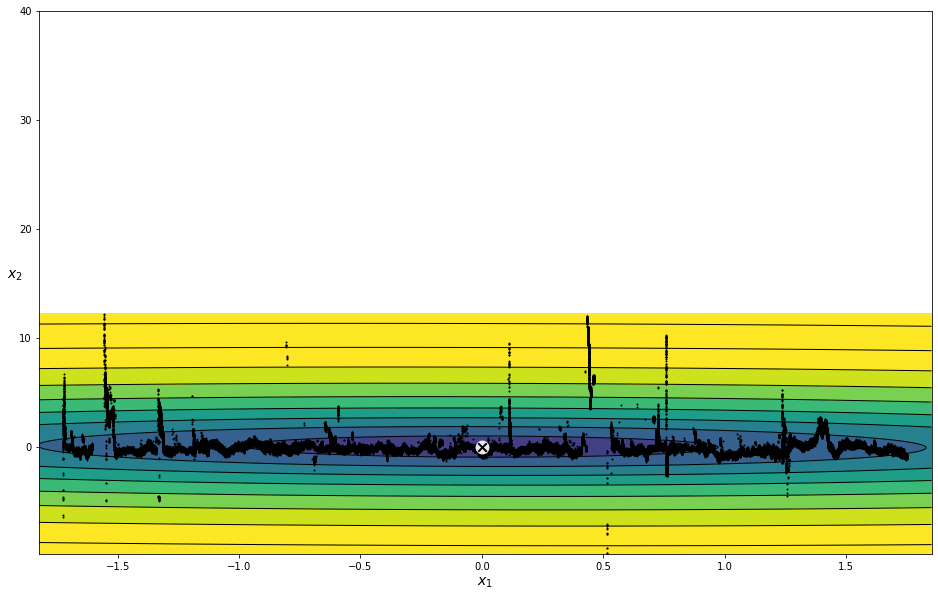

In [25]:
plt.figure(figsize=(16, 10))

plot_gaussian_mixture(gm, height_data_imputed)
plt.ylim(top=40)
# save_fig("gaussian_mixtures_plot")
plt.show()

<ipython-input-24-0c652766f934>:33: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


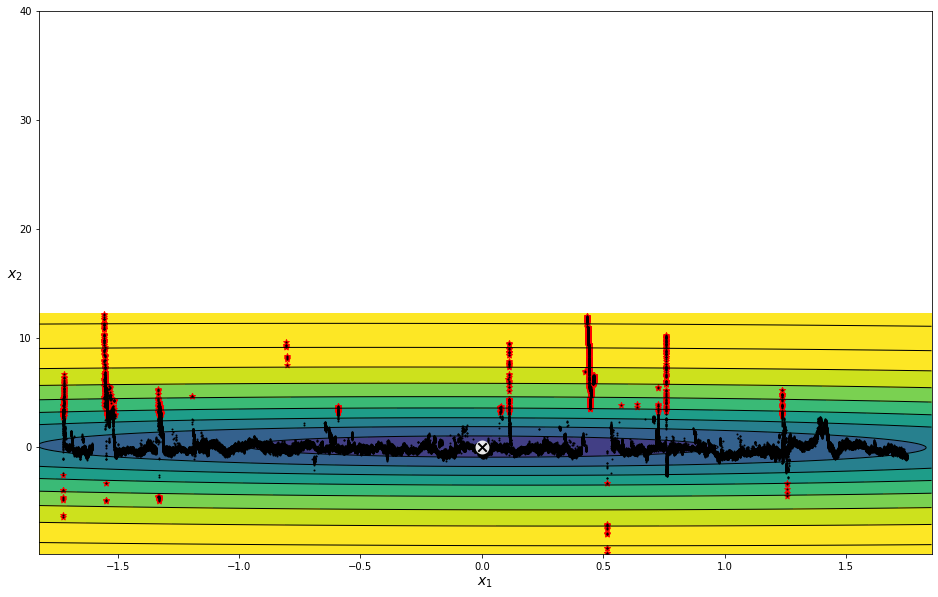

In [26]:
DENSITY_THRESHOLD_PERCENT = 2

densities = gm.score_samples(height_data_imputed)

density_threshold = np.percentile(densities, DENSITY_THRESHOLD_PERCENT)
anomalies = height_data_imputed[densities < density_threshold]



plt.figure(figsize=(16, 10))

plot_gaussian_mixture(gm, height_data_imputed)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=40)

# save_fig("mixture_anomaly_detection_plot")
plt.show()

<AxesSubplot:xlabel='seconds_since_epoch'>

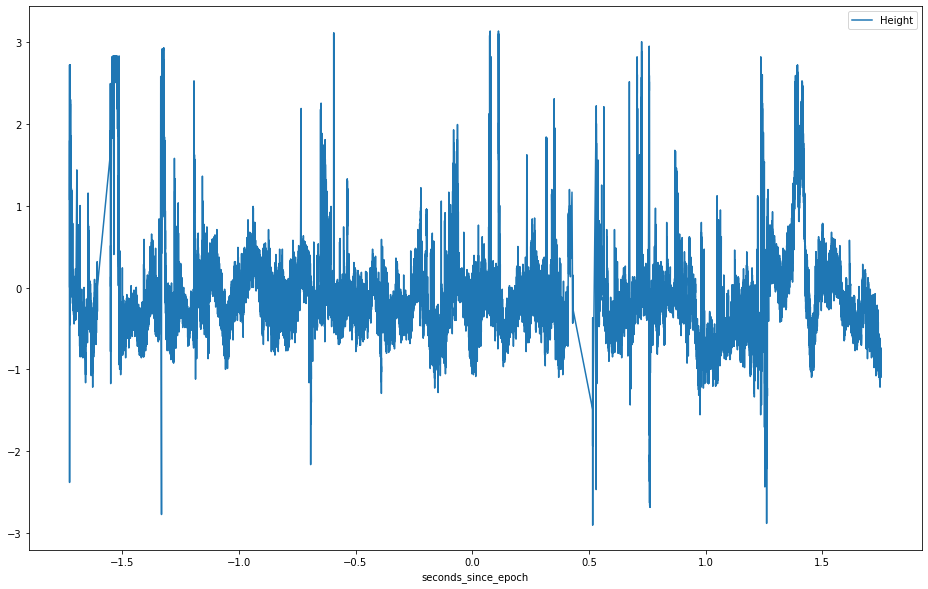

In [30]:
cleaned_data = height_data_imputed[densities >= density_threshold]
cleaned_pandas_data = pd.DataFrame(cleaned_data, columns = ['seconds_since_epoch','Height'])
cleaned_pandas_data.plot(x="seconds_since_epoch", y="Height",figsize=(16, 10))


<AxesSubplot:xlabel='seconds_since_epoch'>

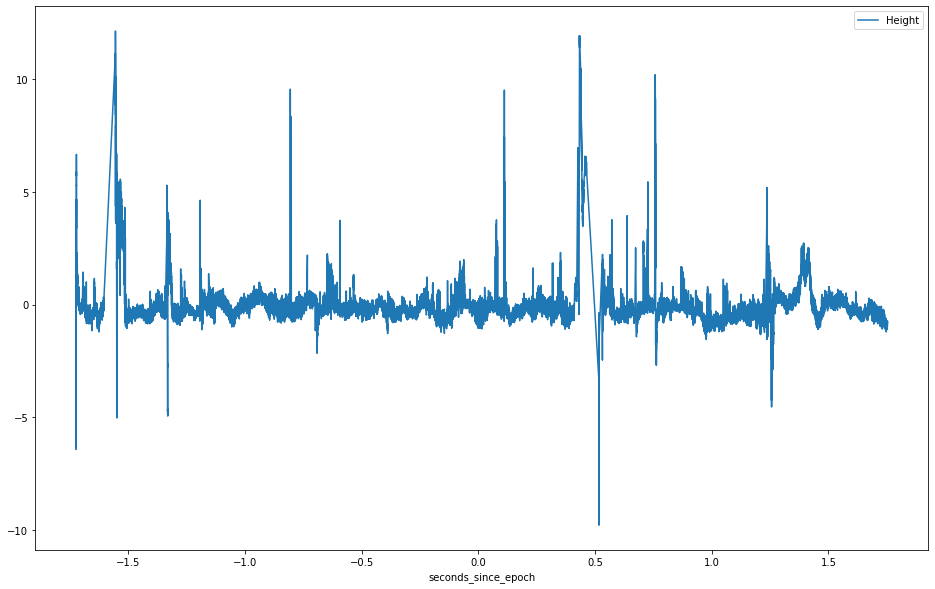

In [31]:
pandas_data = pd.DataFrame(height_data_imputed, columns = ['seconds_since_epoch','Height'])
pandas_data.plot(x="seconds_since_epoch", y="Height",figsize=(16, 10))